# Developer social graph vizualization

This code builds and visualizes the social graph of developers based on data in .csv format  

* **Networkx** is used to create and process the graph  
* **Plotly** is used for visualization. It can be combined with the Dash web framework

## 1) Import, helper functions implementation and constants defining

In [404]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import networkx as nx
import numpy as np
from itertools import combinations
from sklearn import preprocessing
from ast import literal_eval as le
import math


# Parameters:
min_value_for_edge = 0.6
weights_params = {'file_coef': 1, 'time_coef': -0.5}  # Parameters for edges creating
node_size_coef, edge_width_coef = 40, 1

# Constants:
first_date = [2013, 5, 26]  # repository was created (min date)
last_date = [2021, 4, 7]  # data was loaded (max date)
sigma_num = 2  # number of sigma in time interval
users_filename = 'data/users/users.csv'  # A file that contains information about developers
changes_path = 'data/files/'  # Information about changes in files from each developer
commits_path = 'data/commits/'  # Information about commits of developers

# Helper functions
def min_max(iterable):
    # minmax normalization
    m, M = min(iterable), max(iterable)
    denominator = (M - m)
    return list(map(lambda x: (x - m) / denominator, iterable))

def get_min_max(m: float, M: float):
    # Returns minmax function for non iterable object (it should be used in map function)
    denominator = (M - m)
    return lambda x: (x - m) / denominator

def get_interval(sigmas_num: float, data):
    # Returns (mean - std, mean + std) interval
    sigma = np.std(data) * sigmas_num
    mean = np.mean(data)
    return np.array([max(mean - sigma, 0), min(mean + sigma, 1)])

## 2) Graph creating

In [405]:
G = nx.Graph()

users = pd.read_csv(users_filename)['login']
G.add_nodes_from(users)

## 3) Data proccessing

In [406]:
# Weights creating:
edges = [edge for edge in combinations(users, 2)]  # Pairs of users

### 3.1) Data reading, parsing and converting in *pre-feature* condition

In [407]:
# Files intersections:
users_changes = dict()
files_frequency = dict()
for user in users:
    users_changes[user] = set(pd.read_csv(changes_path + user + '_files.csv')['filename'])  # Load changes and link them with author
    for file in users_changes[user]:
        files_frequency[file] = files_frequency.get(file, 0) + 1  # Count frequency to reduce the impact of popular files(like tests, docx or readme)

        
# Dates intersections:
to_days = lambda x: round(x[0] * 365.25 + x[1] * 30 + x[2])  # approximate number of days since the birth of Christ
custom_min_max = get_min_max(to_days(first_date), to_days(last_date))

main_activity_interval = dict()
for user in users:
    commits_in_str = list(pd.read_csv(commits_path + user + '_commits.csv')['commit'])  # Long string from the file
    commits_in_dict = list(map(le, commits_in_str))  # ---------------------------------- Dictionary representation
    times = list(map(lambda x: x['author']['date'], commits_in_dict))  # ---------------- Get time: ---------------- 2019-08-29T23:04:47Z
    dates = list(map(lambda x: x.split('T')[0], times))  # ------------------------------ Just date: --------------- 2019-08-29T23:04:47Z -> 2019-08-29
    splited_dates = list(map(lambda x: [int(elem) for elem in x.split('-')], dates))  # - Date in a convenient form: 2019-08-29 -> [2019, 8, 29]
    date_in_days = list(map(to_days, splited_dates))  # --------------------------------- Date in days form: ------- [2019, 8, 29] -> 737709
    normilized_date = list(map(custom_min_max, date_in_days))
    main_activity_interval[user] = get_interval(sigma_num, normilized_date)


### 3.2) Feature creating

In [408]:
features_matrix = list()
# Files feature:
file_feature = list()
for edge in edges:
    files_intersection = users_changes[edge[0]].intersection(users_changes[edge[1]])  # Overlapping files for a pair of developers
    if files_intersection:
        file_feature.append(len(files_intersection) / sum([files_frequency[file] for file in files_intersection]))  # Remember about the frequency of files from prev block
    else:
        file_feature.append(0)  # No intersections = no links
                                                             
features_matrix.append(min_max(file_feature))
                       
    
# Time feature:
time_feature = list()
for edge in edges:
    time_intersection = np.absolute(main_activity_interval[edge[0]] - main_activity_interval[edge[1]])
    time_feature.append(sum(time_intersection))
                                                        
features_matrix.append(min_max(time_feature))

## 4) Adding fetures in graph

In [409]:
# Weights creating:
weights_vector = np.array(list(weights_params.values())).dot(np.array(features_matrix))
                                                         
# Weights normalization:
normilized_weights = min_max(weights_vector)
    
# Edges creating:
for pair in zip(edges, normilized_weights):
    edge, weight = pair
    if weight > min_value_for_edge:  # Сheck discards minor links from the graff
        G.add_edge(edge[0], edge[1], weight=weight)

## 5) Graph rendering

In [410]:
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='fdp')  # Nodes positions
trace = []  # Traces container

### 5.1) Edge proccessing

In [411]:
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    x=np.linspace(x0*2, x1*2, 15)
    y=np.linspace(y0*2, y1*2, 15)
    # x=tuple([x0*2, x1*2, None]), y=tuple([y0*2, y1*2, None]),
    weight = G.edges[edge]['weight']
    edge_trace = go.Scatter(x=x, y=y,
                            opacity=weight,
                            name=str(weight),
                            hoverinfo='text',
                            mode='lines',
                            line={'width': weight * edge_width_coef, 'color': 'brown'})
    edge_trace.text = \
    f'Edge: {edge}\
    <br>Weight: {round(weight, 2)}'
    
    trace.append(edge_trace)
    
    

### 5.2) Nodes proccessing

In [412]:
node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x*2)
    node_y.append(y*2)
    
# Creating sizes for nodes
size_list = list(map(len, users_changes.values()))
normilized_sizes = np.array(list(map(lambda x: max(0.3, x), min_max(size_list))))

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='deep',
        size=normilized_sizes * node_size_coef,
        colorbar=dict(
            thickness=15,
            title='Adjacency num',
            xanchor='left',
            titleside='right'
        ),
        line_width=1, line_color='red'))

trace.append(node_trace)

# Hover label creating:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(f'Username: {adjacencies[0]}\
                     <br>Files changed: {len(users_changes[adjacencies[0]])}\
                     <br>Activity interval: {np.round(main_activity_interval[adjacencies[0]] * (last_date[0] - first_date[0]) + first_date[0])}\
                     <br>Adjacency num: {len(adjacencies[1])}')

# Hover label adding:
node_trace.marker.color = node_adjacencies
node_trace.text = node_text

### 5.3) Figure creating and rendering

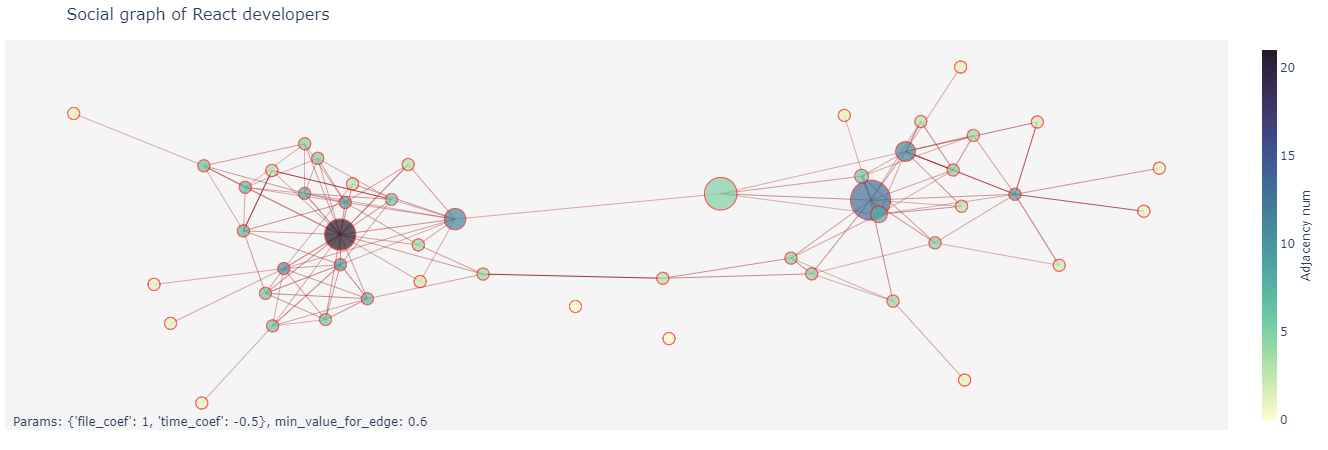

In [413]:
fig = go.Figure(trace,
                layout=go.Layout(
                plot_bgcolor='whitesmoke',
                title='Social graph of React developers',
                titlefont_size=16,
                showlegend=False,
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text=f"Params: {weights_params}, min_value_for_edge: {min_value_for_edge}",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig